# CO2/CH4 retrieved from satellite data vs. ground-based data

+ focus on monthly aggregated $CO_2$, $CH_4$ data
+ satellite data:
    + downloaded from Climate Data Store
    + EMMA algo.
    + years: 2003-present
+ ground-based data:
    + downloaded from esgf
    + project: input4MIPs, era: CMIP6Plus, CMIP7
    + years: 2003-present

In [2]:
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns

# Function to convert the time format
def reformat_date(date_str):
    return datetime.strptime(date_str, "%Y-%m")


In [92]:
def join_data(gas = "co2"):
    gb_df = pd.read_csv(f"../ground-based-data/datasets/agg_{gas}_2003-present.csv")
    sat_df = pd.read_csv("../satellite-data/datasets/merged_emma_df.csv")

    # prepare the CO2-satellite data
    sat_df["year_month"] = sat_df["year"].astype(str)+"-"+sat_df["month"].astype(str)
    sat = sat_df[sat_df["lat"] > 0].groupby(["year_month", "year", "month"]).agg({gas: "mean"}).reset_index()
    sat["method"] = "sat-emma-north"

    # prepare the CO2 ground-based data
    gb = gb_df[["year_month", "values", "version", "year", "month"]]
    gb = gb.rename(columns={"values": gas, "version": "method"})

    # join data sets
    joined_df = pd.concat([sat, gb], join="outer")
    joined_df["year_month"]=[reformat_date(date) for date in joined_df.year_month.values]
    return joined_df

joined_df = join_data(gas = "co2")

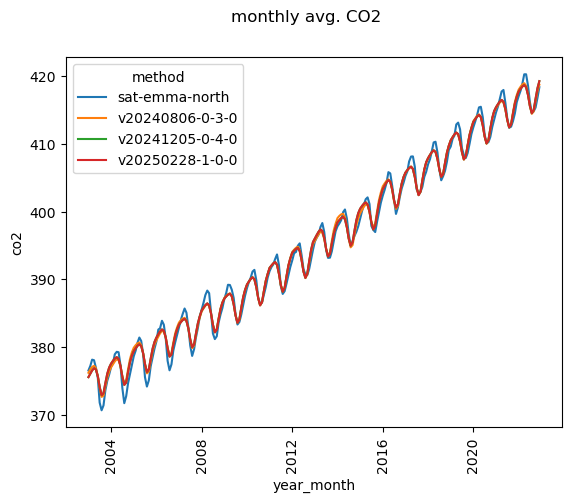

In [90]:
fig, ax = plt.subplots()
sns.lineplot(x="year_month",y="co2", hue="method", data=joined_df)
ax.tick_params(axis='x', labelrotation=90)
fig.suptitle("monthly avg. CO2")
plt.show()